In [40]:
#Using Census API to obtain information of interest to choose a city when buying a property
# code by Sue Del Carpio Bellido

# Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from census import Census
import seaborn as sns

# Census API Key
from config import api_key

c = Census(api_key, year=2016)

In [41]:
zipcodes_df = pd.read_csv("zipcodes_in_LA_counties.csv")
zipcodes_df = zipcodes_df.rename(columns={"zip": "Zipcode","County":"City"})

zipcodes_df.head()

,City,Zipcode
0,Los Angeles,90001
1,Los Angeles,90002
2,Los Angeles,90003
3,Los Angeles,90004
4,Los Angeles,90005


In [42]:
#Filter only selected cities for analysis
selected_cities=['Alhambra','Burbank','Inglewood','Glendale','Long Beach','Los Angeles','Palmdale','Pasadena','Santa Clarita','Torrance']
zipcodes_df=zipcodes_df[zipcodes_df['City'].isin(selected_cities)]
zipcodes_df

,City,Zipcode
0,Los Angeles,90001
1,Los Angeles,90002
2,Los Angeles,90003
3,Los Angeles,90004
4,Los Angeles,90005
5,Los Angeles,90006
6,Los Angeles,90007
7,Los Angeles,90008
8,Los Angeles,90009
9,Los Angeles,90010


In [43]:
##Due to Timeout error, we need to call the API 3 times to obtain all information required

census_data = c.acs5.get(("NAME", "B19013_001E", "B01003_001E", "B01002_001E","B19301_001E","B17001_002E",
                            "B23025_004E","B23025_002E","B23025_005E"),{'for': 'zip code tabulation area:*'})

census_pd = pd.DataFrame(census_data)

census_pd = census_pd.rename(columns={"B01003_001E": "Population",
                                      "B01002_001E": "Median Age",
                                      "B19013_001E": "Household Income",
                                      "B19301_001E": "Per Capita Income",
                                      "B17001_002E": "Poverty Count",
                                      "B23025_004E": "employment_employed",
                                      "B23025_002E": "Labor_force",
                                      "B23025_005E": "employment_unemployed",
                                      "NAME": "Name", "zip code tabulation area": "Zipcode"})

# Add in Poverty Rate (Poverty Count / Population)
census_pd["Poverty Rate"] = 100 * \
    census_pd["Poverty Count"].astype(
        int) / census_pd["Population"].astype(int)

# Add in Poverty Rate (Poverty Count / Population)
census_pd["Employment Rate"] = 100 * \
    census_pd["employment_employed"].astype(
        int) / census_pd["Labor_force"].astype(int)
    
# Add in Poverty Rate (Poverty Count / Population)
census_pd["Unemployment Rate"] = 100 * \
    census_pd["employment_unemployed"].astype(
        int) / census_pd["Labor_force"].astype(int)
    
#Final DataFrame
census_pd = census_pd[["Zipcode", "Population", "Median Age", "Household Income",
                       "Per Capita Income", "Poverty Count", "Poverty Rate","employment_employed","Labor_force","employment_unemployed",
                      "Employment Rate", "Unemployment Rate"]]

# Visualize
print(len(census_pd))
census_pd.head()

33120


,Zipcode,Population,Median Age,Household Income,Per Capita Income,Poverty Count,Poverty Rate,employment_employed,Labor_force,employment_unemployed,Employment Rate,Unemployment Rate
0,01001,17423.0,45.0,56714.0,30430.0,1462.0,8.391207,8715.0,9211.0,479.0,94.615134,5.200304
1,01002,29970.0,23.2,48923.0,26072.0,8351.0,27.864531,15180.0,16451.0,1271.0,92.274026,7.725974
2,01003,11296.0,19.9,2499.0,3829.0,54.0,0.478045,4258.0,5279.0,1021.0,80.659216,19.340784
3,01005,5228.0,44.1,70568.0,32169.0,230.0,4.399388,2835.0,2988.0,153.0,94.879518,5.120482
4,01007,14888.0,42.5,80502.0,36359.0,1410.0,9.470715,8050.0,8593.0,543.0,93.680903,6.319097


In [44]:
census_data_2 = c.acs5.get(("NAME", "B01002_002E", "B01002_003E", "B08136_011E","B15003_002E","B01001_002E",
                            "B01001_026E"),{'for': 'zip code tabulation area:*'})

census_pd_2 = pd.DataFrame(census_data_2)

census_pd_2 = census_pd_2.rename(columns={"B01002_002E": "Median_male_age",
                                      "B01002_003E": "Median_female_age",
                                      "B08136_011E": "Walkable_time_min", 
                                      "B15003_002E": "Education_none",
                                      "B01001_002E": "Male_population",
                                      "B01001_026E": "Female_population",
                                      "NAME": "Name", "zip code tabulation area": "Zipcode"})

#Final DataFrame
census_pd_2 = census_pd_2[["Zipcode", "Median_male_age", "Median_female_age", "Walkable_time_min","Education_none", 
                           "Male_population", "Female_population"]]

# Visualize
print(len(census_pd_2))
census_pd_2.head()

33120


,Zipcode,Median_male_age,Median_female_age,Walkable_time_min,Education_none,Male_population,Female_population
0,01001,41.6,48.1,NaN,69.0,8059.0,9364.0
1,01002,23.3,23.2,19100.0,212.0,14536.0,15434.0
2,01003,19.9,19.9,NaN,0.0,5694.0,5602.0
3,01005,41.6,47.4,NaN,0.0,2798.0,2430.0
4,01007,40.2,43.8,NaN,18.0,7224.0,7664.0


In [45]:
census_data_3 = c.acs5.get(("NAME", "B14002_001E", "B16003_002E", "B16003_008E","B19083_001E"),{'for': 'zip code tabulation area:*'})

# Convert to DataFrame
census_pd_3 = pd.DataFrame(census_data_3)

# Column Reordering
census_pd_3 = census_pd_3.rename(columns={"B14002_001E": "Students_population",
                                       "B16003_002E": "Population_from_5_17",
                                       "B16003_008E": "Population_18_over",
                                       "B19083_001E": "Gini_index",
                                      "NAME": "Name", "zip code tabulation area": "Zipcode"})
    
#Final DataFrame
census_pd_3 = census_pd_3[["Zipcode", "Students_population", "Population_from_5_17", "Population_18_over","Gini_index"]]
                        
# Visualize
print(len(census_pd_3))
census_pd_3.head()

33120


,Zipcode,Students_population,Population_from_5_17,Population_18_over,Gini_index
0,01001,17029.0,14.0,153.0,0.4052
1,01002,29476.0,71.0,564.0,0.5258
2,01003,11296.0,0.0,0.0,0.5861
3,01005,5156.0,0.0,0.0,0.4053
4,01007,14518.0,9.0,263.0,0.4300


In [46]:
# Merge two dataframes using an inner join
merge_table_1 = pd.merge(census_pd, census_pd_2, on="Zipcode")
merge_table_1.head()
print(len(merge_table_1))

33120


In [47]:
# Merge two dataframes using an inner join
merge_table_total = pd.merge(merge_table_1, census_pd_3, on="Zipcode")
merge_table_total.head()
#print(len(merge_table_total))

,Zipcode,Population,Median Age,Household Income,Per Capita Income,Poverty Count,Poverty Rate,employment_employed,Labor_force,employment_unemployed,...,Median_male_age,Median_female_age,Walkable_time_min,Education_none,Male_population,Female_population,Students_population,Population_from_5_17,Population_18_over,Gini_index
0,01001,17423.0,45.0,56714.0,30430.0,1462.0,8.391207,8715.0,9211.0,479.0,...,41.6,48.1,NaN,69.0,8059.0,9364.0,17029.0,14.0,153.0,0.4052
1,01002,29970.0,23.2,48923.0,26072.0,8351.0,27.864531,15180.0,16451.0,1271.0,...,23.3,23.2,19100.0,212.0,14536.0,15434.0,29476.0,71.0,564.0,0.5258
2,01003,11296.0,19.9,2499.0,3829.0,54.0,0.478045,4258.0,5279.0,1021.0,...,19.9,19.9,NaN,0.0,5694.0,5602.0,11296.0,0.0,0.0,0.5861
3,01005,5228.0,44.1,70568.0,32169.0,230.0,4.399388,2835.0,2988.0,153.0,...,41.6,47.4,NaN,0.0,2798.0,2430.0,5156.0,0.0,0.0,0.4053
4,01007,14888.0,42.5,80502.0,36359.0,1410.0,9.470715,8050.0,8593.0,543.0,...,40.2,43.8,NaN,18.0,7224.0,7664.0,14518.0,9.0,263.0,0.4300


In [48]:
#Export clean data
merge_table_total.to_csv("Clean_Data/total_census.csv", encoding="utf-8", index=False, header=True)

# Cleaning Data

In [49]:
#Get only Zipcodes from LA selected cities
import numpy as np
merge_table_total['Zipcode']=merge_table_total['Zipcode'].astype(np.int64)

los_angeles_census_df = pd.merge(merge_table_total, zipcodes_df, on="Zipcode")
los_angeles_census_df.to_csv("Clean_data/los_angeles_census.csv", encoding="utf-8", index=False, header=True)

In [50]:
los_angeles_census_df.columns

Index(['Zipcode', 'Population', 'Median Age', 'Household Income',
       'Per Capita Income', 'Poverty Count', 'Poverty Rate',
       'employment_employed', 'Labor_force', 'employment_unemployed',
       'Employment Rate', 'Unemployment Rate', 'Median_male_age',
       'Median_female_age', 'Walkable_time_min', 'Education_none',
       'Male_population', 'Female_population', 'Students_population',
       'Population_from_5_17', 'Population_18_over', 'Gini_index', 'City'],
      dtype='object')

In [51]:
# Dropping results with population=0
population_greater_0 = los_angeles_census_df["Population"]>0
los_angeles_census_df=los_angeles_census_df[population_greater_0]

In [52]:
##We found default value in census is "-666666666"
##We are going to filter this data for each analysis


#Group by City, aggregation average by Gini index
gini_index_value = los_angeles_census_df["Gini_index"]>-666666666
gini_index_df = los_angeles_census_df[gini_index_value]

gini_index_df = gini_index_df.groupby(["City"])['Gini_index'].agg(['mean']).sort_index().reset_index()
gini_index_df= gini_index_df.rename(columns={"mean":"Gini_index_avg"})

gini_index_df=gini_index_df.sort_values(by='Gini_index_avg', ascending=False)
gini_index_df

,City,Gini_index_avg
7,Pasadena,0.509271
5,Los Angeles,0.490941
2,Glendale,0.466180
0,Alhambra,0.451150
1,Burbank,0.450520
3,Inglewood,0.437020
4,Long Beach,0.432907
9,Torrance,0.427600
6,Palmdale,0.407150
8,Santa Clarita,0.395511


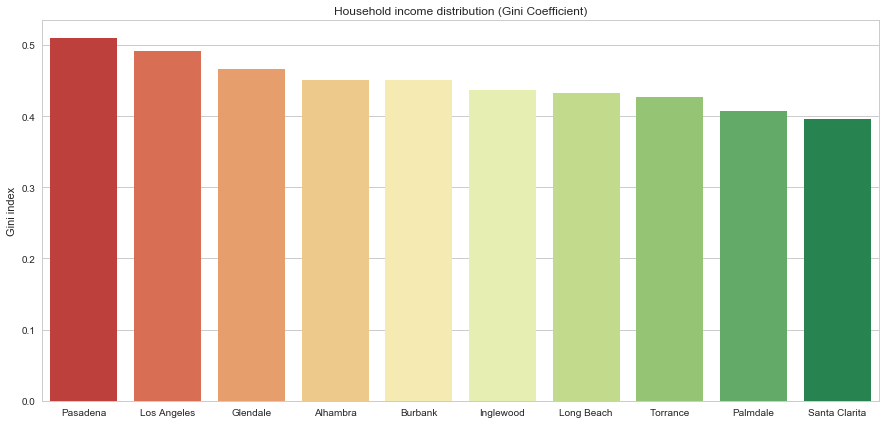

In [61]:
#Plot with seaborn, make additional changes with matplotlib
#Palette color reflects values from negative to positive for better understand

sns.set_style("whitegrid")
plt.figure(figsize=(15,7))
sns.barplot(x="City", y="Gini_index_avg", data=gini_index_df, palette=sns.color_palette("RdYlGn", 10))

plt.xlabel("")
plt.ylabel("Gini index")
plt.title("Household income distribution (Gini Coefficient)")

plt.show()

# Save the figure
plt.savefig("Clean_Data/Gini_index_by_City.png")

# UNEMPLOYMENT AND POVERTY ANALYSIS 

In [56]:
##Clean and preparing data
unemployment_value = los_angeles_census_df["Unemployment Rate"]>-666666666
poverty_value = los_angeles_census_df["Poverty Rate"]>-666666666

poverty_unemployment_df = los_angeles_census_df[unemployment_value & poverty_value]

poverty_unemployment_df = poverty_unemployment_df.groupby(["City"])[['Unemployment Rate','Poverty Rate']].agg(['mean']).sort_index().reset_index()

poverty_unemployment_df.columns = poverty_unemployment_df.columns.droplevel(1)

poverty_unemployment_df= poverty_unemployment_df.rename(columns={"Unemployment Rate":"Unemployment_Rate","Poverty Rate":"Poverty_Rate"})

poverty_unemployment_df


,City,Unemployment_Rate,Poverty_Rate
0,Alhambra,5.762571,14.708418
1,Burbank,8.814113,12.450008
2,Glendale,7.809085,14.231462
3,Inglewood,12.604107,21.751611
4,Long Beach,8.892041,16.633681
5,Los Angeles,10.441077,23.850274
6,Palmdale,13.823630,21.388886
7,Pasadena,6.459477,13.638440
8,Santa Clarita,7.729977,7.996643
9,Torrance,7.536710,9.708102


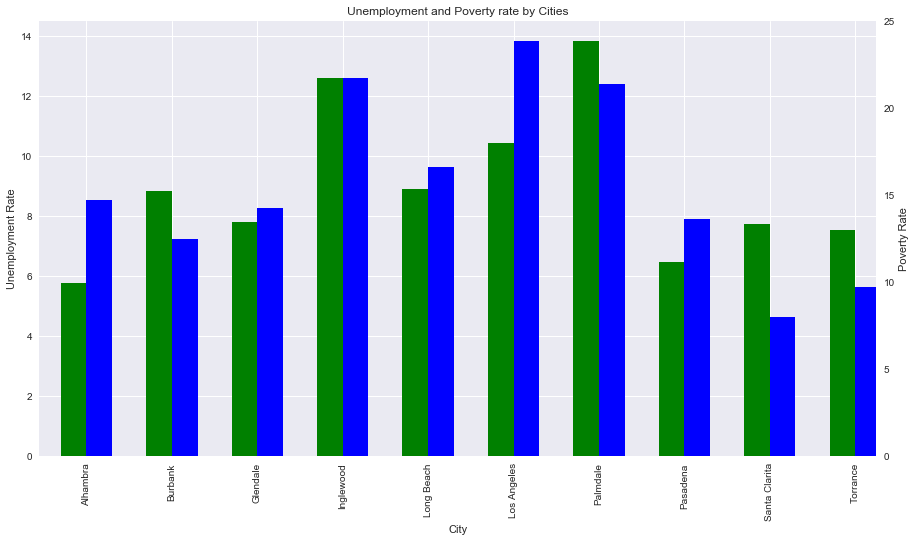

In [57]:
#Plot unemployment rate and poverty rate in two columns to compare results

sns.set()
poverty_unemployment_df = poverty_unemployment_df.set_index('City')

fig = plt.figure(figsize=(15,8)) # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as a
width = .3

poverty_unemployment_df.Poverty_Rate.plot(kind='bar',color='blue', ax=ax2,width = width,position=0)

poverty_unemployment_df.Unemployment_Rate.plot(kind='bar',color='green',ax=ax,width=width, position=1)
ax.grid(None, axis=1)
ax2.grid(None)

ax.set_ylabel('Unemployment Rate')
ax2.set_ylabel('Poverty Rate')
plt.title("Unemployment and Poverty rate by Cities")
# Save the figure
plt.savefig("Clean_Data/Unemployment_Poverty_rate_by_City.png")

# WALKABLE ANALYSIS

In [58]:
##Clean and preparing data
walk_time_value = los_angeles_census_df["Walkable_time_min"]>-666666666
walk_time_value_df = los_angeles_census_df[walk_time_value]

walk_time_value_df = walk_time_value_df.groupby(["City"])['Walkable_time_min'].agg(['sum']).sort_index().reset_index()
walk_time_value_df= walk_time_value_df.rename(columns={"sum":"Walkable_time_min_total"})

walk_time_value_df=walk_time_value_df.sort_values(by='Walkable_time_min_total', ascending=True)
walk_time_value_df

,City,Walkable_time_min_total
0,Alhambra,1775.0
3,Inglewood,5935.0
6,Palmdale,5945.0
8,Santa Clarita,7285.0
2,Glendale,10110.0
9,Torrance,11565.0
1,Burbank,13860.0
7,Pasadena,40900.0
4,Long Beach,55145.0
5,Los Angeles,465885.0


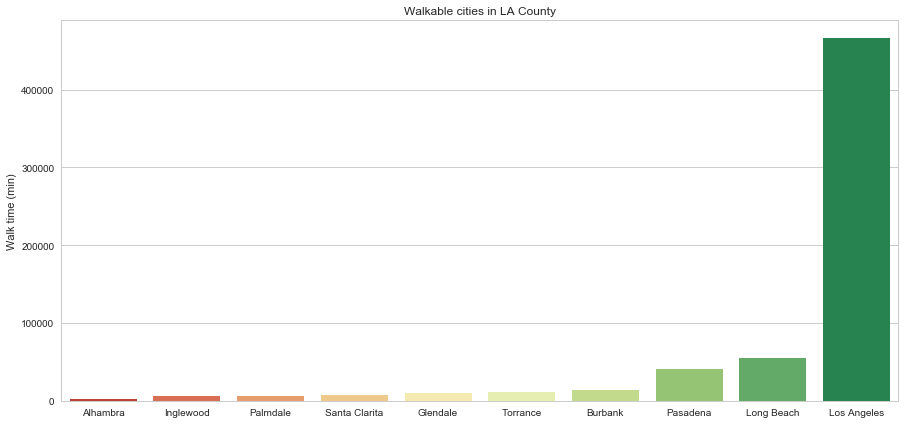

In [62]:
sns.set_style("whitegrid")
plt.figure(figsize=(15,7))
sns.barplot(x="City", y="Walkable_time_min_total", data=walk_time_value_df, palette=sns.color_palette("RdYlGn", 10))

plt.xlabel("")
plt.ylabel("Walk time (min)")
plt.title("Walkable cities in LA County")

# Save the figure
plt.savefig("Clean_Data/Walk_time_by_City.png")

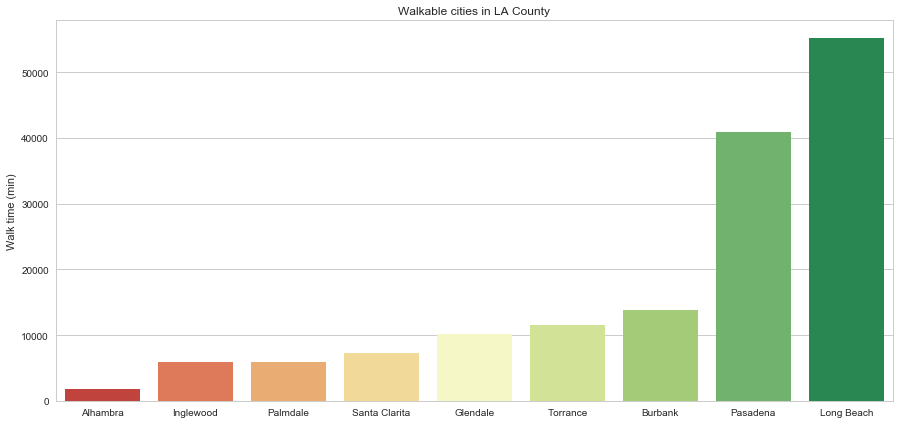

In [67]:
##Same analysis, without LA
selected_cities_no_la=['Alhambra','Burbank','Inglewood','Glendale','Long Beach','Palmdale','Pasadena','Santa Clarita','Torrance']
walk_time_value_no_la_df=walk_time_value_df[walk_time_value_df['City'].isin(selected_cities_no_la)]
walk_time_value_no_la_df

sns.set_style("whitegrid")
plt.figure(figsize=(15,7))
sns.barplot(x="City", y="Walkable_time_min_total", data=walk_time_value_no_la_df, palette=sns.color_palette("RdYlGn", 9))

plt.xlabel("")
plt.ylabel("Walk time (min)")
plt.title("Walkable cities without LA")

# Save the figure
plt.savefig("Clean_Data/Walk_time_by_City_no_la.png")

# AGE ANALYSIS

In [63]:
##Clean and preparing data
median_age_value = los_angeles_census_df["Median Age"]>-666666666
median_male_age_value = los_angeles_census_df["Median_male_age"]>-666666666
median_female_age_value = los_angeles_census_df["Median_female_age"]>-666666666


age_stats_df = los_angeles_census_df[median_age_value & median_male_age_value & median_female_age_value]
age_stats_df = age_stats_df.groupby(["City"])[['Median Age','Median_male_age','Median_female_age']].agg(['mean']).sort_index().reset_index()
age_stats_df.columns = age_stats_df.columns.droplevel(1)
age_stats_df = age_stats_df.rename(columns={"Median Age":"Median_age"})

age_stats_df.head()

,City,Median_age,Median_male_age,Median_female_age
0,Alhambra,41.300000,38.850000,43.10
1,Burbank,39.540000,38.660000,40.84
2,Glendale,40.440000,38.090000,41.84
3,Inglewood,33.920000,32.540000,35.32
4,Long Beach,36.092857,35.157143,37.00


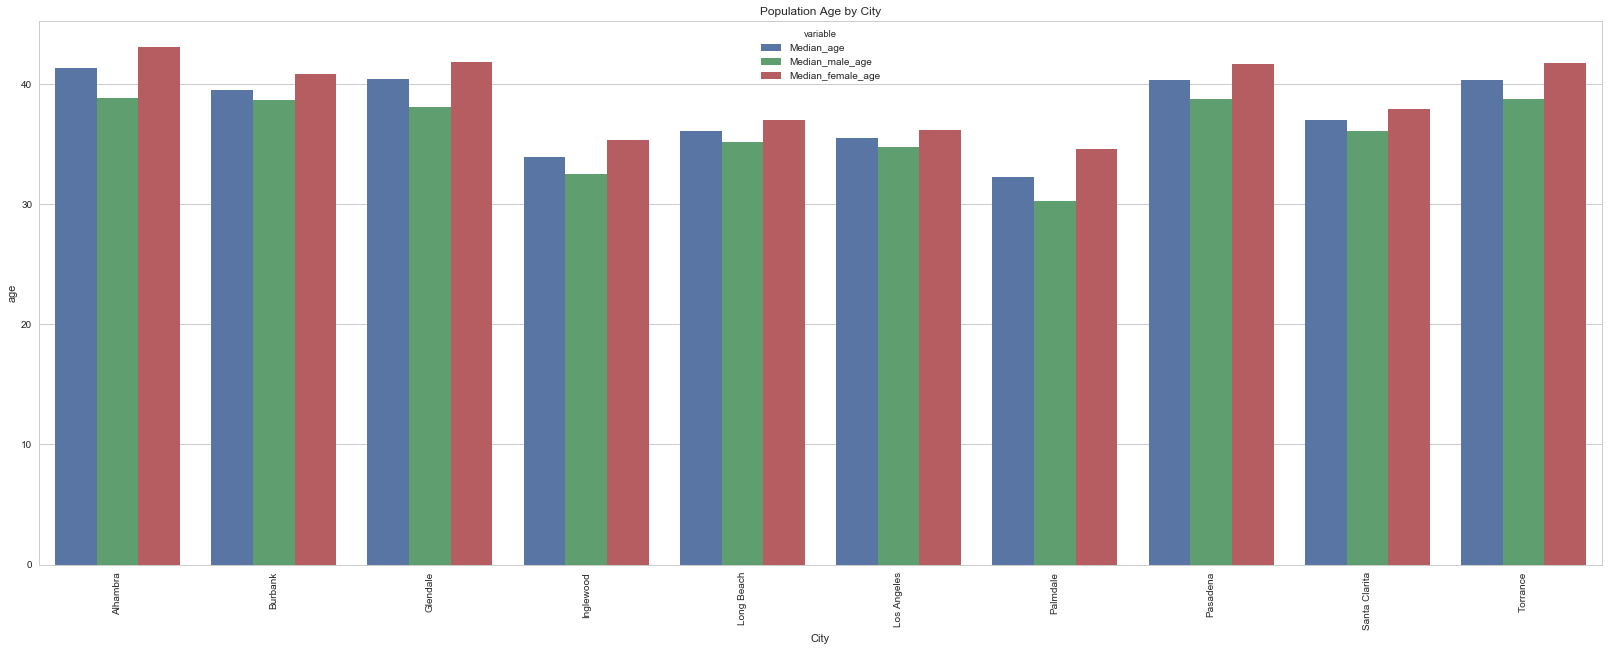

In [64]:
##Unpivot data for Seaborn plots
sns.set_style("whitegrid")
age_stats_df_plot=age_stats_df[['City','Median_age','Median_male_age','Median_female_age']]

age_stats_df_upivot=pd.melt(age_stats_df_plot, id_vars=['City'], value_vars=['Median_age', 'Median_male_age','Median_female_age'])

cities=age_stats_df[['City']]

plt.figure(figsize=(28,10))
sns.barplot(x='City', y='value', hue='variable', data=age_stats_df_upivot)
plt.xticks(rotation=90)

plt.ylabel('age')
plt.title('Population Age by City')
plt.show()

# Save the figure
plt.savefig("Clean_Data/Age_analysis_city.png")

# EDUCATION ANALYSIS

In [65]:
##Clean and preparing data
Education_none_value = los_angeles_census_df["Education_none"]>-666666666

education_df = los_angeles_census_df[Education_none_value]

education_df = education_df.groupby(["City"])[['Education_none','Population']].agg(['sum']).sort_index().reset_index()
education_df.columns = education_df.columns.droplevel(1)

# Add in Education none Rate (Education none Count / Population)
education_df["Education_none_Rate"] = 100 * \
    education_df["Education_none"].astype(
        int) / education_df["Population"].astype(int)
    
education_df=education_df.sort_values(by='Education_none_Rate', ascending=False)
education_df

,City,Education_none,Population,Education_none_Rate
0,Alhambra,3267.0,84767.0,3.854094
4,Long Beach,18840.0,575287.0,3.274887
5,Los Angeles,68843.0,2678395.0,2.570308
2,Glendale,4844.0,209444.0,2.312790
3,Inglewood,2828.0,135412.0,2.088441
6,Palmdale,2965.0,174283.0,1.701256
1,Burbank,1683.0,108133.0,1.556417
7,Pasadena,2330.0,169915.0,1.371274
9,Torrance,2033.0,176673.0,1.150713
8,Santa Clarita,1989.0,283616.0,0.701300


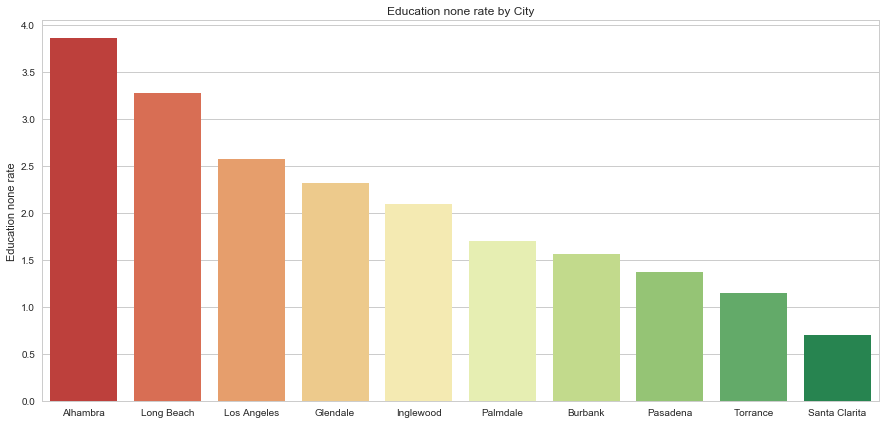

In [66]:
sns.set_style("whitegrid")
plt.figure(figsize=(15,7))
sns.barplot(x="City", y="Education_none_Rate", data=education_df, palette=sns.color_palette("RdYlGn", 10))

plt.xlabel("")
plt.ylabel("Education none rate")
plt.title("Education none rate by City")

# Save the figure
plt.savefig("Clean_Data/Education_none_by_City.png")